In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from pyprojroot import here
import seaborn as sns

import searchnets

In [2]:
VSD_ROOT = here().joinpath('results/VSD/checkpoints')
NET_EXPT_ROOTS = [path for path in sorted(VSD_ROOT.iterdir()) if path.is_dir()]

In [3]:
cornet_z_expt_roots = [path for path in NET_EXPT_ROOTS if 'CORnet_Z' in str(path)]

convert all tensorboard events files to .csv (only need to run this once)

In [6]:
for cornet_z_expt_root in cornet_z_expt_roots:
    net_roots = sorted(cornet_z_expt_root.joinpath('trained_200_epochs').glob('net_number*'))
    for net_root in net_roots:
        events_file = sorted(net_root.glob('**/*events*'))
        events_file = [path for path in events_file if not str(path).endswith('.csv')]
        assert len(events_file) == 1, 'found more than one events file'
        events_file = events_file[0]
        logdir = events_file.parent
        searchnets.tensorboard.logdir2csv(logdir)

In [7]:
def get_net_number_from_dirname(dirname):
    return dirname.split('_')[-1]

In [8]:
expt_dfs = {}

for cornet_z_expt_root in cornet_z_expt_roots:
    expt_name = cornet_z_expt_root.name.replace('CORnet_Z_', '')  # will use as dict key
    
    dfs_this_expt = []
    net_roots = sorted(cornet_z_expt_root.joinpath('trained_200_epochs').glob('net_number*'))
    for net_root in net_roots:
        net_number = int(
            get_net_number_from_dirname(net_root.name)
        )
        
        events_csv = sorted(net_root.glob('**/*events*csv'))
        assert len(events_csv) == 1, 'found more than one events file'
        events_csv = events_csv[0]
        df = pd.read_csv(events_csv)
        df['replicate'] = net_number
        dfs_this_expt.append(df)
        expt_dfs[expt_name] = pd.concat(dfs_this_expt)

In [9]:
expt_dfs['transfer_BCE'].columns

Index(['step', 'loss/train', 'loss/val', 'f1/val', 'acc_largest/val',
       'acc_random/val', 'replicate'],
      dtype='object')

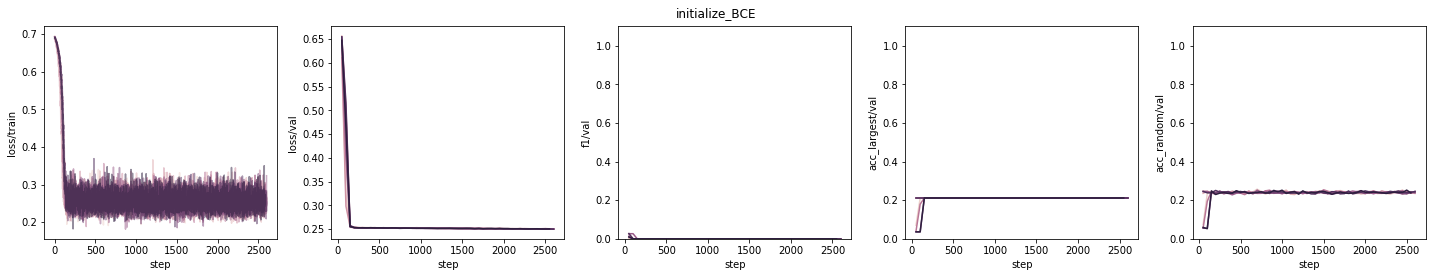

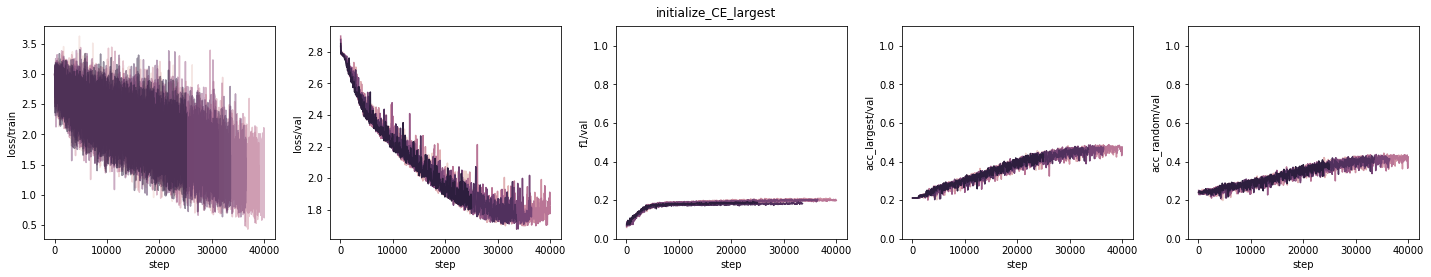

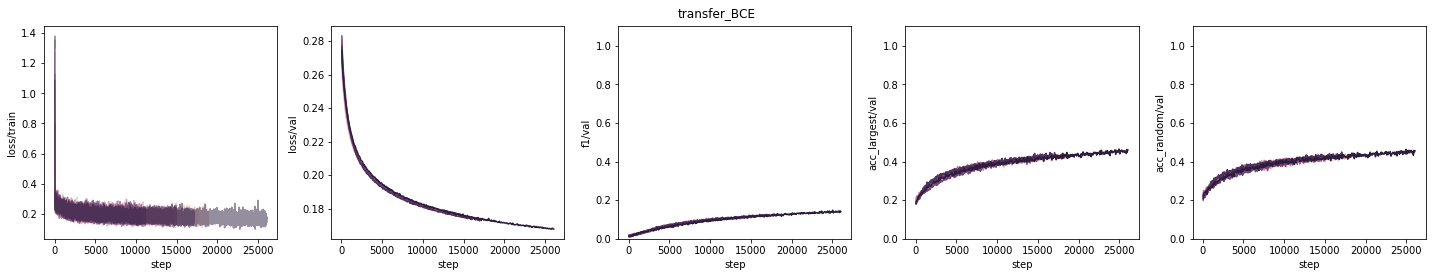

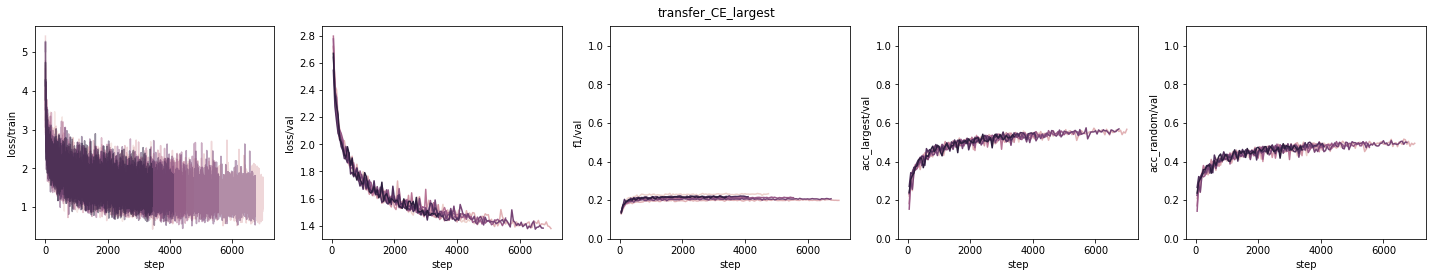

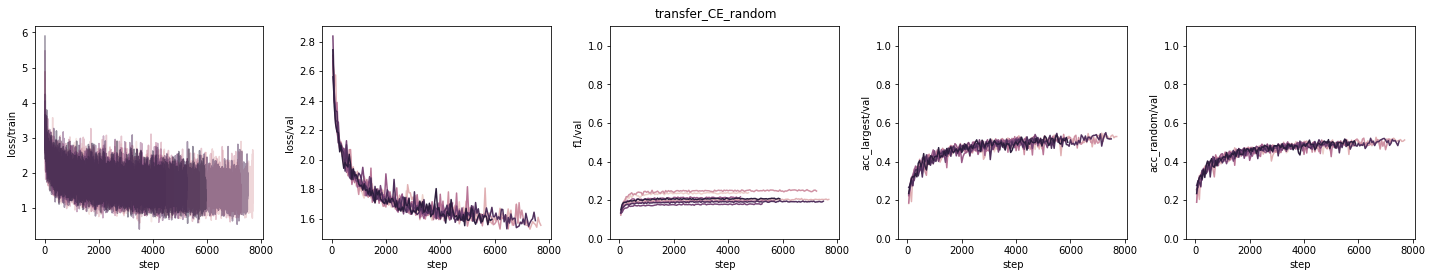

In [10]:
for expt_name in expt_dfs.keys():
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    ax = ax.ravel()
    sns.lineplot(x='step', y='loss/train', hue='replicate', data=expt_dfs[expt_name], 
                 ci=None, legend=False, alpha=0.5, ax=ax[0]);
    # ax[0].set_ylim([0., 0.7])
    sns.lineplot(x='step', y='loss/val', hue='replicate', data=expt_dfs[expt_name], 
                 ci=None, legend=False, ax=ax[1]);
    # ax[1].set_ylim([0., 0.7])
    sns.lineplot(x='step', y='f1/val', hue='replicate', data=expt_dfs[expt_name], 
                 ci=None, legend=False, ax=ax[2]);
    ax[2].set_ylim([0., 1.1])
    sns.lineplot(x='step', y='acc_largest/val', hue='replicate', data=expt_dfs[expt_name], 
                 ci=None, legend=False, ax=ax[3]);
    ax[3].set_ylim([0., 1.1])
    sns.lineplot(x='step', y='acc_random/val', hue='replicate', data=expt_dfs[expt_name], 
                 ci=None, legend=False, ax=ax[4]);
    ax[4].set_ylim([0., 1.1])
    st = fig.suptitle(expt_name)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
